# Лабораторна робота №2.
## Згорткова нейронна мережа

У цій лабораторній роботі Ви будете реалізовувати шари згортки (CONV) та субдіскретизації (POOL) в numpy, включаючи як пряме поширення, так і зворотнє.

**Основні позначення**:
- Верхній індекс $[l]$ позначає об'єкт шару $l^{th}$. 
    - Приклад: $a^{[4]}$ це активація шару $4^{th}$ . $W^{[5]}$ та $b^{[5]}$ це параметри шару $5^{th}$.


- Верхній індексt $(i)$ позначає $i^{th}$. 
    - Приклад: $x^{(i)}$ це $i^{th}$ об'єкт з навчальної вибірки.
    
    
- Верхній індекс $i$ позначає запис $i^{th}$ вектора.
    - Приклад: $a^{[l]}_i$ позначає, що $i^{th}$ вхідний вектор активацій в $l$-го шару, за умов, що це повнозв'язний шар (fully connected - FC).
    
    
- $n_H$, $n_W$ та $n_C$ позначають висоту, ширину та кількість каналів даного шару. Якщо ви бажаєте послатися на конкретний шар $l$, Ви можете писати $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ та $n_{C_{prev}}$ позначають відповідно висоту, ширину та кількість каналів попереднього шару. Якщо необхідно звернутися до певного (попереднього) шару  $l$, це можна зробити наступним чином  $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

Для виконання цієї лабораторної роботи Вам необхідно знати як користуватись бібліотекою `numpy` або уважно прочитати специфікації до цієї бібліотеки!  

Під час виконання вам дозволено користуватися будь-якими зручними для вас бібліотеками.  

Роботи ідентифіковані як ІДЕНТИЧНІ  або роботи БЕЗ висновків одразу отримують 0 балів.


## Підказки

* `conv_forward` має додаткові підказки, які допоможуть студентам, якщо вони застрягли.
* `conv_forward` розміщує код для` vert_start` та `vert_end` всередині циклу` for h in range (...) `; щоб уникнути зайвих розрахунків. Аналогічно для `horiz_start` та` horiz_end`.
* `conv_forward` розбиває однорядковий розрахунок` Z [i, h, w, c] `на 3 рядки, для більшої наглядності.
* Тест "conv_forward" перевіряє, чи ви випадково не використовуєте n_H_prev замість n_H, використовуючить n_W_prev замість n_W, і випадково не змінюючи n_H на n_W
* `pool_forward` належним чином опрацьовує ` vert_start`, `vert_end`,` horiz_start` та `horiz_end`, щоб уникнути зайвих обчислень.
* `pool_forward` має два нові тестові випадки, які перевіряють правильність реалізації кроку (висота і ширина активацій попереднього шару повинні бути достатньо великими щодо розмірів фільтра, щоб можна було здійснити крок).
* `conv_backward`: ініціалізує змінні` Z` та `кеш` в рамках модульного тесту, щоб зробити його незалежним від тестування, яке відбувається у розділі` conv_forward` відповідно.


## 1 - Основні бібліотеки

Для початку необхідно імпортувати всі необхідні бібліотеки, які Вам  вам знадобляться під час виконання цієї лабораторної роботи:
- [numpy](www.numpy.org) це основна бібліотека для інтелектуальних обчислень даних в Python.
- [matplotlib](http://matplotlib.org) це бібліотека для побудови графіків в Python.
- np.random.seed(1) ця "фіча" необхідна для перевірки Вас;) 

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Етапи виконання лабораторної роботи

Ви будете реалізувати окремі "будівельні" блоки згорткової нейронної мережі! Кожна функція, яку Ви будете реалізовувати, містить детальні інструкції, які допоможуть Вам виконати наступні кроки:

- Функція згортки (Convolution functions), містить:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Функція субдискретизації (Pooling functions), містить:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
Модель конволюційної нейронної мережі має наступний вигляд. 
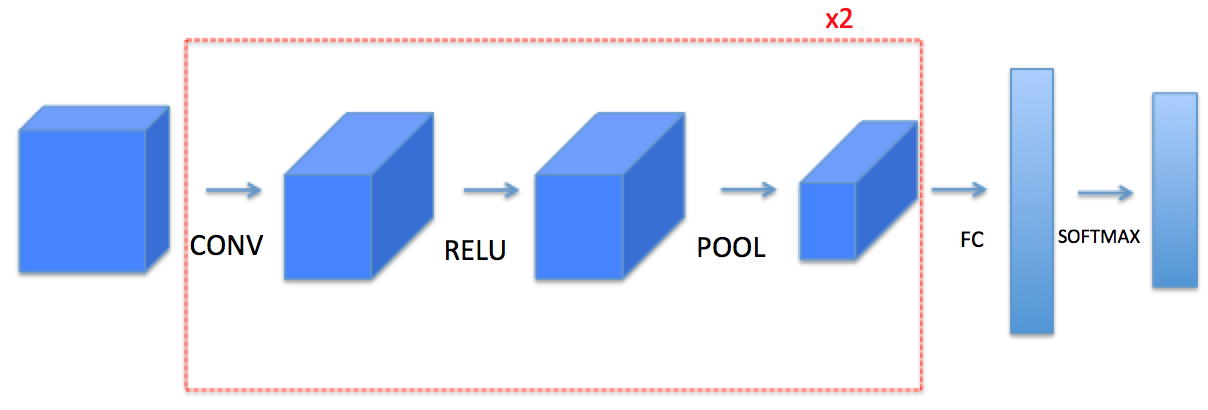

**Зверніть увагу**, що для кожної функції прямого поширення існує відповідний еквівалент функції зворотного поширення. Отже, на кожному кроці вашого модуля прямого поширення ви будете зберігати деякі параметри в кеші. Ці параметри використовуються для обчислення градієнтів під час зворотного поширення.

## 3 - Згорткова нейромережа


Хоча бібліотеки роблять процедуру згортки простою у використанні, ці нейронні мережі залишаються одними з найскладніших  для розуміння концепцій мереж в межах глибокого навчання. Шар згортки перетворює вхідний масив у вихідний різного розміру, як показано нижче.

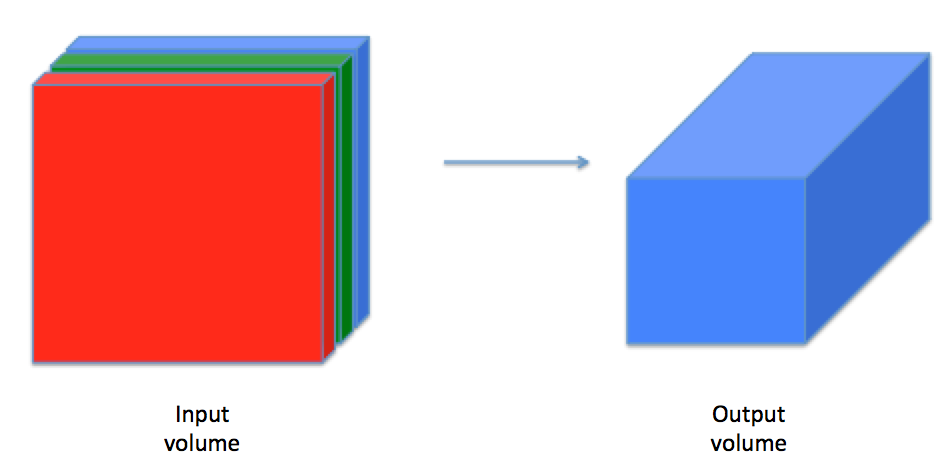

У цій частині лабораторної роботи Ви побудуєте шар згортки. Спочатку Ви реалізуєте дві допоміжні функції: одну для `zero padding`, а іншу для обчислення самої функції згортки `convolution function`.

### 3.1 - Zero-Padding

Zero-padding додає нулі навколо межі зображення:

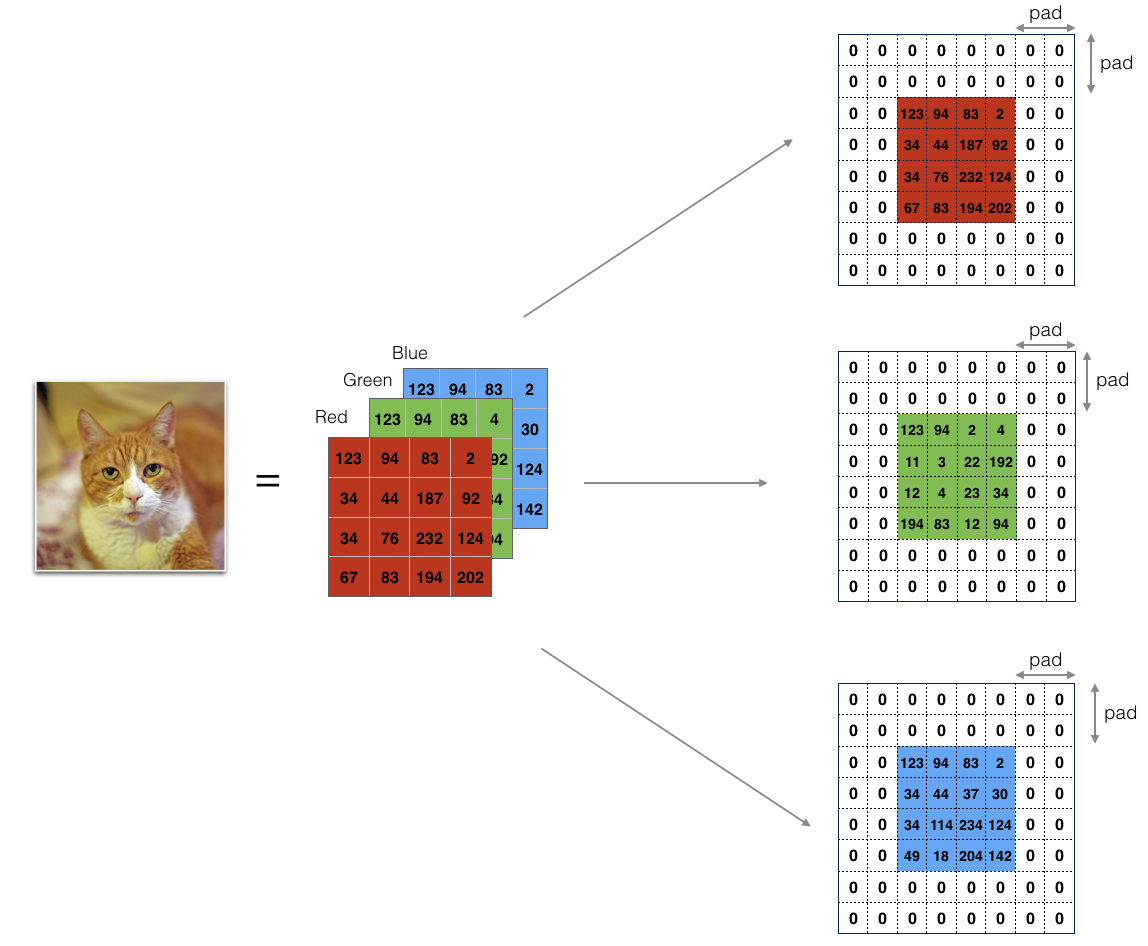
<caption><center> <u> <font color='purple'> **Рисунок 1** </u><font color='purple'>  : **Zero-Padding**<br> Зображення (3 канала, RGB) та padding розмірністю 2. </center></caption>

Чому необхідно використовувати Zero-padding:

- Це дозволяє використовувати шар CONV без додаткового зменшення висоти та ширини. Це важливо для побудови глибинних мереж, оскільки в іншому випадку висота/ширина зменшуватиметься при переході на більш глибокі шари. Важливим окремим випадком є "та сама" згортка, в якій висота/ширина точно зберігається після одного шару.

- Це допомагає зберігати більше інформації на межі зображення. Без відступу пікселі впливатимуть на дуже невеликі значення на наступному шарі як краї зображення.

**Завдання 1**: Реалізуйте наведену нижче функцію, яка доповнює всі зображення сету прикладів X нулями. [Використання np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). 
Зверніть увагу, якщо ви хочете додати масив "а" форми $ (5,5,5,5,5) $ з `pad = 1` для 2 -ї розмірності,` pad = 3` для 4 -ї розмірності та `pad = 0 'для решти, необхідно зробити наступне:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [2]:
# GRADED FUNCTION: zero_pad

def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), mode = 'constant', constant_values = (0,0))
    
    return X_pad

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


**Результат, який необхідно отримати**:

```
x.shape = 
(4, 3, 3, 2)
x_pad.shape = 
(4, 7, 7, 2)
x[1,1] = 
[[ 0.90085595 -0.68372786]
[-0.12289023 -0.93576943]
[-0.26788808  0.53035547]]
x_pad[1,1] = 
[[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]
[ 0.  0.]]
```

### 3.2 - Згортка

У цій частині Вам необхідно реазлізувати згортку, для цього необхідно  застосувати фільтр до єдиного положення входу. Це буде використано для побудови згорткової одиниці, яка: 

- Приймає вхідний масив; 
- Застосовує фільтр для кожного значення вхідного масиву; 
- Повертає вихідний сигнал (зазвичай вже пониженої розмірності);

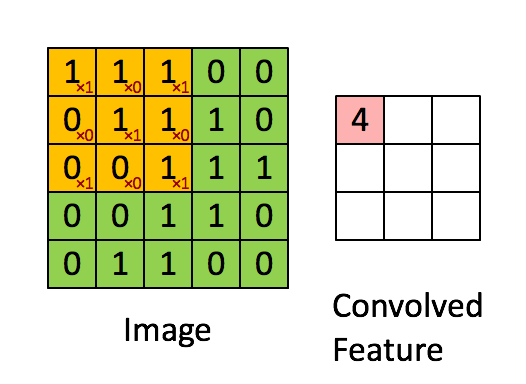
<caption><center> <u> <font color='purple'> **Рисунок 2** </u><font color='purple'>  : **Операція згортки**<br> з фільтром (ядро згортки) 3x3 </center></caption>
 
При реалізації процедури згортки кожне значення в матриці ліворуч відповідає одному пікселю, кожне значення вхідного масиву має бути помножине на значення фільтру (ядро згортки) 3x3. Після цього необхідно скласти всі ці значення та додати зміщеня.  

**Завдання 2**: Реалізуйте функцію conv_single_step(). [документація](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html). В цьому завдання Ви реалізуєте єдиний крок згортки, що відповідає застосуванню фільтра лише до однієї з позицій, щоб отримати єдиний результат реального значення.



**Примітка**: Змінна b буде передана як масив `numpy`. Якщо ми додамо скаляр (з `float` чи `integer`) до масиву `numpy`, результатом буде масив `numpy`. В окремому випадку, коли масив `numpy` містить одне значення, можна відтворити його як `float` для перетворення в скаляр.

In [4]:
# GRADED FUNCTION: conv_single_step

def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """

    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = a_slice_prev * W
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z += float(b)

    return Z

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


**Результат, який необхідно отримати**:
<table>
    <tr>
        <td>
            **Z**
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

### 3.3 - Згорткова нейронна мережа - пряме поширення

У прямому поширенні вам треба взяти багато фільтрів і "згорнути" їх на вході. Кожна "згортка" дає  двовимірний матричний вихід. Потім необхідно скласти ці результати, щоб отримати трехвимірну матрицю:

<center>
<video width="620" height="440" src="conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**Завдання 3**: 
Реалізуйте наведену нижче функцію, щоб конвертувати фільтри `W` на вхідну активацію` A_prev`.  
Ця функція приймає такі вхідні дані:
* `A_prev`, значення активацій з попереднього шару ( для сету з  m входім); 
* Вагові коефіцієнти позначаються як `W`.  Розмір вікна фільтру позначається `f`.
* Вектор зміщення позначається як `b`, де кожен фільтр має власний сигнал зміщення. 

У Вас також є доступ до словника гіперпараметрів.

**Підказка**:
1. Щоб вибрати вікно 2х2 у верхньому лівому куті матриці "a_prev" (розмірності (5,5,3)), потрібно зробити:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```  
Зверніть увагу, що 3D -вікно,  має висоту 2, ширину 2 і глибину 3. Глибина - це кількість каналів.
Це стане в нагоді, коли ви визначите "a_slice_prev", використовуючи задані Вами індекси "start/end".
2. Щоб визначити a_slice, вам потрібно спочатку визначити  кути `vert_start`,` vert_end`, `horiz_start` та` horiz_end`.

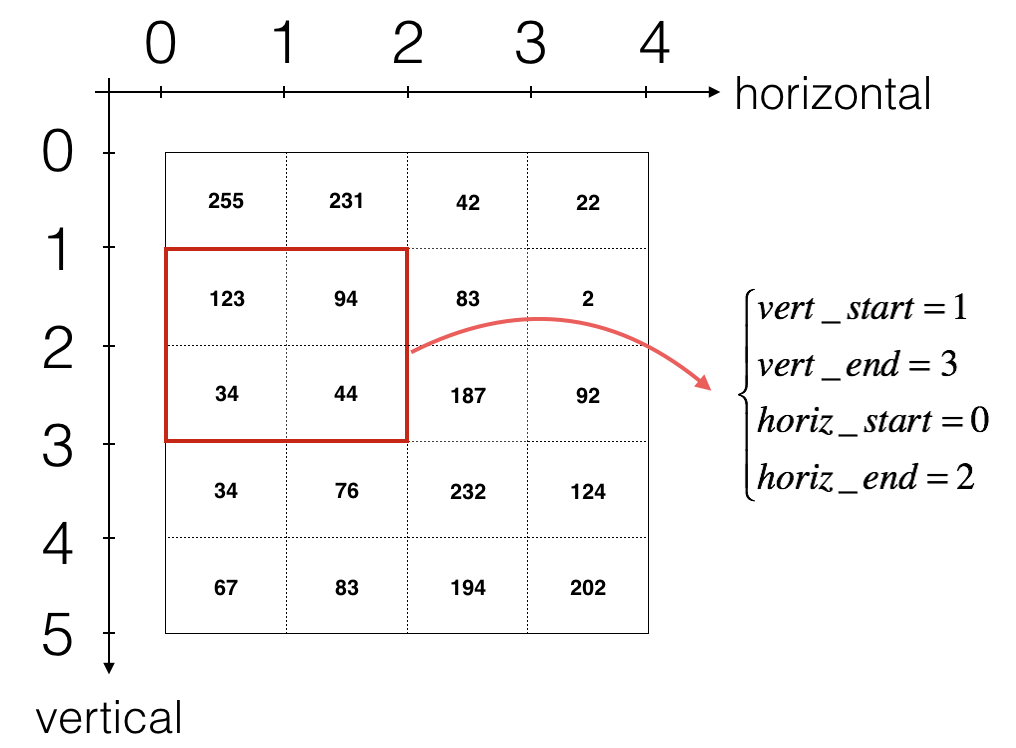
<caption><center> <u> <font color='purple'> **Рисунок 3** </u><font color='purple'>  : **Визначення зрізу за допомогою вертикального та горизонтального початку/кінця (з фільтром 2x2)** <br> на рисунку проілюстровано виключно для одного каналу </center></caption>


**Нагадування**:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{ кількість фільтрів, що використовується в конволюції}$$

В цій частині лабораторної роботи все реалізується за допомогою циклів.

#### Додаткові підказки


* Можна використати "нарізку" масиву (наприклад`varname[0:1,:,3:5]`) fдля наступних змінних:  
  `a_prev_pad` ,`W`, `b`  
  Скопіюйте код та запустіть його за межами визначеної функції в окремих клітинках.
   Переконайтеся, що підмножина кожного масиву є необхідного розміру та розмірності. 
* Пам'ятайте, що vert_start, vert_end; horiz_start, horiz_end, це індекси попереднього шару!   
  Індекси вихідного шару позначаються `h` та `w`.  
* Переконайтеся, що `a_slice_prev` має висоту, ширину та глибину.
* Пам’ятайте, що `a_prev_pad` є підмножиною` A_prev_pad`.
   Подумайте, який із них слід використовувати в циклах for.

In [6]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
  
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters" (≈2 lines)
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. Hint: use int() to floor. (≈2 lines)
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W =int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialize the output volume Z with zeros. (≈1 line)
    Z = np.zeros([m, n_H, n_W, n_C])
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]                              # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            vert_start = h*stride
            vert_end = h*stride + f
            for w in range(n_W):  
                horiz_start = w*stride 
                horiz_end = w*stride + f
                for c in range(n_C):                   # loop over chann
                    
                    horiz_start = w*stride 
                    horiz_end = w*stride + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell).
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:, :, :, c])
                    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


**Результат, який необхідно отримати**:
```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```

Нарешті, шар CONV також повинен містити функцію активації, для цього необхідно додати наступний коду:

**Приклад**
```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```


## 4 - Шар субдискретизації (Pooling layer)

Шар субдискретизації або пулінгу (POOL) зменшує висоту та ширину вхідної матриці. Це допомагає зменшити обчислення, а також допомагає зробити детектори функцій більш інваріантними до свого положення на вході. Інсує два типи пулінгу:

- Max-pooling layer: ковзне вікно ($f, f$), яке зберігає максимальне значення у  сигналі на виході.

- Average-pooling layer: ковзне вікно ($f, f$), яке зберігає середнє значення у сигналі на виході.

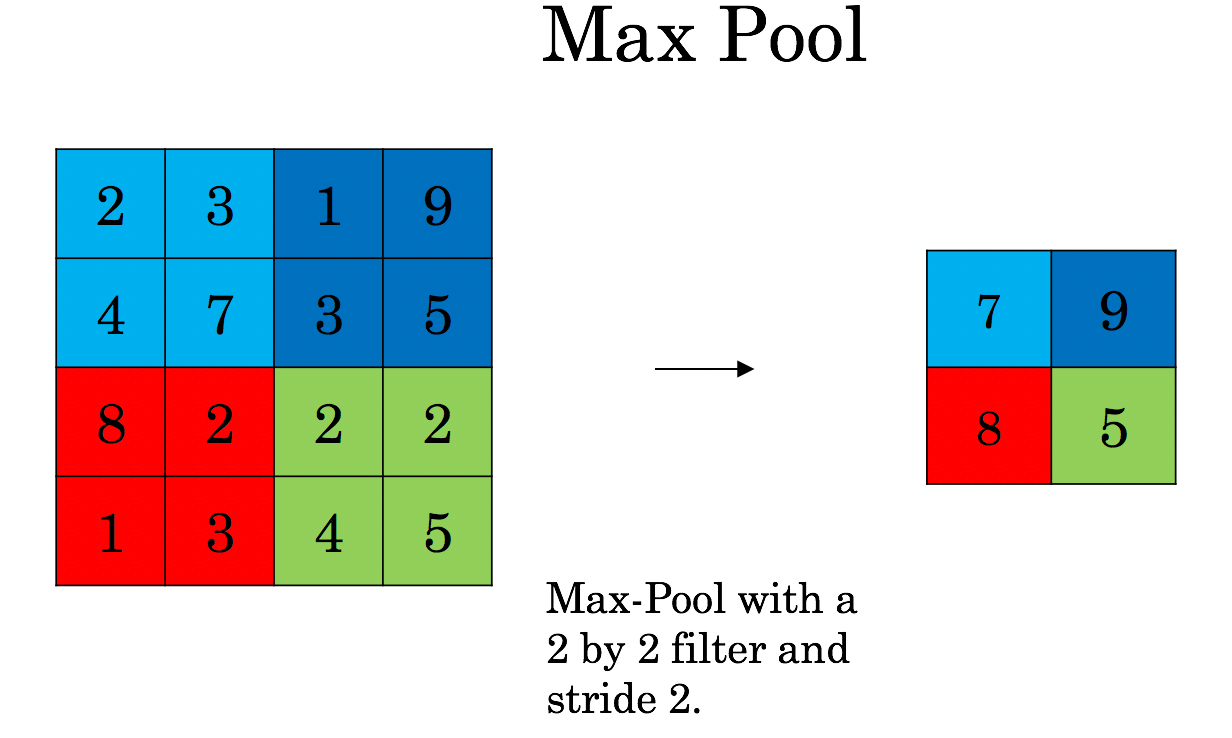



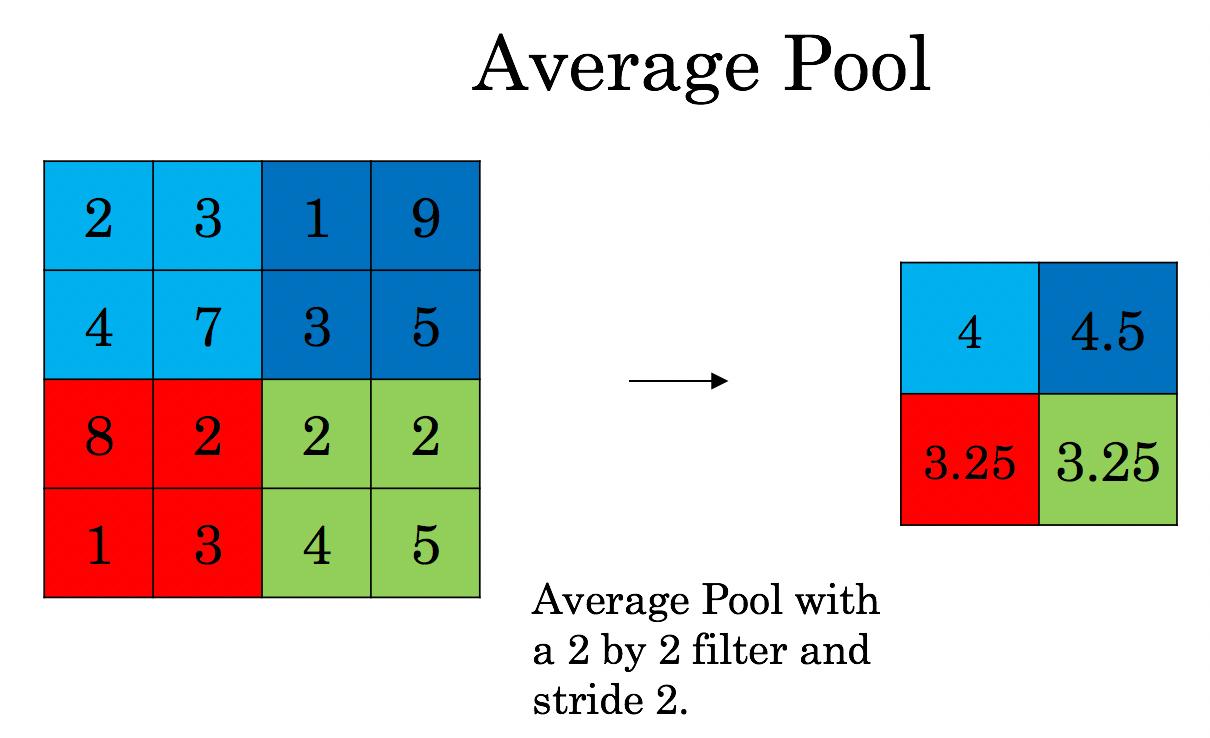

Шари пулінгу не мають параметрів для навчання мережі на основі методу зворотного пошірення. Однак у них є гіперпараметри, такі як розмір вікна пулінгу $ f $. Це вказує на висоту та ширину вікна $ f \ times f $, для якого потрібно обчислити * max * або * average *.

### 4.1 - Субдискретизація на основі методу прямого поширення
Тепер Вам необхідно реалізувати MAX-POOL та AVG-POOL у одній і тій самій функції.

**Завдання 4:** Реалізуйте метод прямого поширення для шару субдискретизації. Дотримуйтесь підказок у коментарях нижче.


$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [14]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):   
            vert_start = h*stride
            vert_end = h*stride +f
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                horiz_start = w*stride
                horiz_end = w*stride + f
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. Use an if statment to differentiate the modes. Use np.max/np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [15]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

**Результат, який необхідно отримати**
```
mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-01]]

  [[ -3.81801899e-01   1.59993515e-02   1.70562706e-01]
   [  4.73707165e-02   2.59244658e-02   9.20338402e-02]
   [  3.97048605e-02   1.57189094e-01   3.45302489e-01]]

  [[ -3.82680519e-01   2.32579951e-01   6.25997903e-01]
   [ -2.47157416e-01  -3.48524998e-04   3.50539717e-01]
   [ -9.52551510e-02   2.68511000e-01   4.66056368e-01]]]


 [[[ -1.73134159e-01   3.23771981e-01  -3.43175716e-01]
   [  3.80634669e-02   7.26706274e-02  -2.30268958e-01]
   [  2.03009393e-02   1.41414785e-01  -1.23158476e-02]]

  [[  4.44976963e-01  -2.61694592e-03  -3.10403073e-01]
   [  5.08114737e-01  -2.34937338e-01  -2.39611830e-01]
   [  1.18726772e-01   1.72552294e-01  -2.21121966e-01]]

  [[  4.29449255e-01   8.44699612e-02  -2.72909051e-01]
   [  6.76351685e-01  -1.20138225e-01  -2.44076712e-01]
   [  1.50774518e-01   2.89111751e-01   1.23238536e-03]]]]
```

In [16]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]


**Результат, який необхідно отримати:**
    
```
mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]
```

На цьому етапі Ви реалізували метод прямого поширення для згорткової нейронної мережі!!!


## 5 - Метод зворотного поширення в згорткових нейронних мережах

В попередній лабораторній роботи Ви використовували метод зворотного поширення для обчислення похідних щоб оцінити параметри мережі і визначити на скільки добре нейронна мережа навчилась. Аналогічно, у згорткових нейронних мережах можна обчислити похідні відностно функції втрат, щоб оновити параметри. Рівняння зворотного зв'язку не є тривіальними

### 5.1 - Реалізація зворотного поширення в шарі згортки

Почнемо з реалізації зворотного поширення для шару CONV.

#### 5.1.1 - Обчислення похідної dA:
Це формула для обчислення $ dA $ щодо функції втрат певного фільтра $ W_c $ та поточного прикладу з навчальної вибірки:

$$ dA += \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

де $ W_c $ - фільтр, а $ dZ_ {hw} $ - скаляр, що відповідає градієнту функції втрат відносно виходу шару згортки Z у h -му рядку та w -му стовпці (відповідає скалирному добутку, взятому на i -й крок вліво і j -й крок вниз). Зверніть увагу на те, що кожного разу ми помножуємо один і той самий фільтр $ W_c $ на інший dZ під час оновлення dA. Ми робимо це головним чином тому, що під час обчислення прямого поширення кожен фільтр ставиться пунктиром і підсумовується різним a_slice. Тому при обчисленні зворотного поширення для dA ми просто додаємо градієнти всіх a_slices.

У коді всередині відповідних циклів `for` ця формула має наступний запис:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

#### 5.1.2 - Обчислення похідної dW:
Це формула для обчислення $ dW_c $ ($ dW_c $ є похідною від одного фільтра) відностно функції втрат:

$$ dW_c  += \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

де $ a_ {slice} $ відповідає частині, яка була використана для створення активації $ Z_ {ij} $. Отже, це в кінцевому підсумку дає нам градієнт для вагових коефіцієнтів $ W $ щодо цього $ a_ {slice} $. Оскільки ми працюємо з тим самим $ W $, ми просто додаємо всі такі градієнти, щоб отримати похідну по $ dW $.

В коді це буде мати наступний запис:

```python
dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
```

#### 5.1.3 - Обчислення похідної db:

Формула для обчислення похідної $ db $ відностно функції втрат певного фільтра $ W_c $ має наступний вигляд:

$$ db = \sum_h \sum_w dZ_{hw} \tag{3}$$

Як і в першій лабораторній роботі, похідна по db обчислюється шляхом складання всіх похідних $ dZ $. У цьому випадку розраховується сумма всіх градієнтів шару згортки (Z) відностно функції втрат.

В коді це буде мати наступний запис:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

**Завдання 5:** Реалізуйте функцію `conv_backward`. Вам необхідно просумувати всі спостереження з навчальної вибірки, фільтри, висоти та ширини. Потім слід обчислити похідні за формулами 1, 2 і 3.

In [19]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    ### START CODE HERE ###
    # Retrieve information from "cache"
    (A_prev, W, b, hparameters) = cache
    
    # Retrieve dimensions from A_prev's shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Retrieve dimensions from dZ's shape
    (m, n_H, n_W, n_C) = dZ.shape
    
    # Initialize dA_prev, dW, db with the correct shapes
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))

    # Pad A_prev and dA_prev
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):                   # loop over vertical axis of the output volume
            vert_start = h
            vert_end = vert_start + f
            for w in range(n_W):               # loop over horizontal axis of the output volume
                horiz_start = w
                horiz_end = horiz_start + f
                for c in range(n_C):           # loop over the channels of the output volume
                    # Use the corners to define the slice from a_prev_pad
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [20]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 0.6347704472654743
dW_mean = 1.5572657428497354
db_mean = 7.839232564616838


**Результат, який необхідно отримати:**
<table>
    <tr>
        <td>
            **dA_mean**
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            **dW_mean**
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            **db_mean**
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


## 5.2 Шар субдискретизації на основі зворотного поширення

В цій частині лабораторної роботи Вам необхідно реалізувати зворотнє поширення для шару субдискретизації. Зверніть увагу на те, що у шарі субдискретизації немає параметрів для оновлення зворотного поширення, але все рівно потрібно повернути градієнт назад через шар субдискретизації, щоб обчислити градієнти для попередніх шарів.

### 5.2.1 Max pooling - зворотнє поширення  

Перед тим як розпочати реалізовувати зворотнє поширення для шару субдикретизації, необхідно створити  допоміжну функцію `create_mask_from_window ()`, яка буде виконувати наступне:

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$
 
Ця функція створює матрицю "маски", яка відстежує, де знаходиться максимум матриці. Значення (1) вказує на позицію максимуму в X, інші записи зі значенням (0) - хибні.

**Завдання 6:** Реалізуйте функцію `create_mask_from_window()`. Ця функція буде необхідна для реалізації зворотного поширення для шару субдискретизації.  

Підказка:
- [np.max()]() знаходить максимальне значення масиву.
- Якщо є матриця X та скаляр x: `A = (X == x)` поверне матрицю тієї ж розмірності, що і матриця X:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- Розглядати випадки, коли в матриці є кілька максимумів не потрібно.

In [21]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """
    
    mask = x == np.max(x)

    
    return mask

In [22]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


**Результат, який необхідно отримати:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
**mask =**
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

Для того, щоб уникнути ефекту "зникаючого" градієнту необхідно слідкувати за положенням максимуму матриці!

### 5.2.2 - Average pooling - зворотнє поширення 

В max pooling, для кожного вікна згортки обирається єдине значення - максимальне. Якщо використовується average pooling, то необхідно знайти середнє значення по кожному із вікон згортки
 
Наприклад, якщо `Average pooling` для прямого поширення використовує фільтр розмірності  2x2, то маска, яка буде використовуватися для зворотного поширення, буде мати наступний вигляд:
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

Це означає, що кожний елемент матриці $dZ$ буде мати однаковий вплив на вихідний сигнал. 

**Завдання 7:** Реалізуйте функцію, яка ділить значення dz в матриці. [Підказка](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [23]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    # Retrieve dimensions from shape (≈1 line)
    (n_H, n_W) = shape
    
    # Compute the value to distribute on the matrix (≈1 line)
    average = dz / (n_H * n_W)
    
    # Create a matrix where every entry is the "average" value (≈1 line)
    a = np.ones(shape) * average
    
    return a

In [24]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


**Результат, який необхідно отримати**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

### 5.2.3 Шар субдискретизації на основі зворотного поширення

**Завдання 8:** Реалізуйте функцію `pool_backward` в обох режимах (` `max '' і` `average ''). Вам необхідно буде використовувати 4 цикли for. Також необхідно використовувати оператор `if/elif`, щоб перевірити `max` та `average` значення. у випадку коли Ви отримуєте "середнє" значення, Вам слід скористатися функцією `distribute_value ()`, щоб створити матрицю тієї ж розмірності, що і` a_slice`. В іншому випадку, коли Ви отримуєте максимальне значення, необхідно створити маску  `create_mask_from_window ()` і помножити її на відповідне значення dA.

In [25]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """

    # Retrieve information from cache (≈1 line)
    (A_prev, hparameters) = cache
    
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    # Initialize dA_prev with zeros (≈1 line)
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       # loop over the training examples
        # select training example from A_prev (≈1 line)
        a_prev = A_prev[i]
        for h in range(n_H):                   # loop on the vertical axis
            vert_start = h
            vert_end = vert_start + f
            for w in range(n_W):  
                horiz_start = w
                horiz_end = horiz_start + f
                for c in range(n_C):           # loop over the channels (depth)                    
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice (≈1 line)
                        mask = create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                        
                    elif mode == "average":
                        # Get the value a from dA (≈1 line)
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf (≈1 line)
                        shape = (f, f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
                        
     # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [26]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


**Результат, який необхідно отримати**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1] =** 
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

**mean of dA=**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
**dA_prev[1,1]=** 
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>